# ENVIRONMENT

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, adfuller, coint, pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# suppress scientific notation in Pandas
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("precision", 3)
pd.set_option("display.max_colwidth", None)

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 150

sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

import warnings

warnings.filterwarnings("ignore")

RANDOM_STATE = 1

original_df = pd.read_csv("./src/churn/teleco_time_series.csv")
df = original_df.copy()


# Introduction 

In the telecom munications industry, customers can choose from multiple service providers and actively switch from one provider to another. Customer churn is defined as the percentage of customers who stopped using a provider’s product or service during a certain time frame. In this highly competitive market, some telecommunications industries can experience average annual churn rates as high as 25 Given that it costs 10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many providers retaining highly profitable customers is the number one business goal. To reduce customer churn, telecom munications companies need to predict which customers are at high risk of churn.

As part of the “churn” project, executives would like to see consider a time series on revenue from the first years of operation. Once they understand any patterns in that data, they feel confident in understanding the impact of churn in current times. The given time series data records the daily revenue, in million dollars, during the first two years of operation.

**Data File being used:**
teleco_time_series.csv

**Data Dictionary:**
- The data set consists of 731 rows and two columns:
    - Day Day during first two years of operation
    - Revenue Revenue in million dollars
    
Review the data dictionary and considerations related to the raw data file you have chosen and prepare the data for time series modeling. You will then analyze that data set using time series modeling, create visualizations, generate forecasts, and deliver the results of your analysis.

1. Import the initial dataset into a data frame.
0. Clean the data.
0. Difference the data set to coerce stationarity and save it.
0. Split the clean data into training and test sets (80%  training and 20% test).
0. Perform spectral density to see the periodicities.
0. Perform acf / pacf on train dataset to confirm stationarity.
0. Decompose the clean data to see components of the Time Series.
0. Plot the trend, seasonal, and residual components individually.
0. Perform AIC to pick the best order of ARIMA.  
0. Create and fit ARMA(p, q) model using SARIMAX and the model order from AIC
0. Use auto_arima on train_df
0. Fit ARIMA model using hyper-parameters from auto_arima and the training dataset.  
0. Create the time series model using SARIMAX with the model order from AIC.
0. Predict with the test set.
0. Perform forecast on the training set.
0. Validate with test set.
0. Save the model.


# Part 0: Data Exploration

In [15]:
original_df.head()

,Day,Revenue
0,1,0.00
1,2,0.00
2,3,0.83
3,4,0.32
4,5,1.08


In [49]:
original_df.describe()

,Day,Revenue
count,731.00,731.00
mean,366.00,9.82
std,211.17,3.85
min,1.00,0.00
25%,183.50,6.87
50%,366.00,10.79
75%,548.50,12.57
max,731.00,18.15


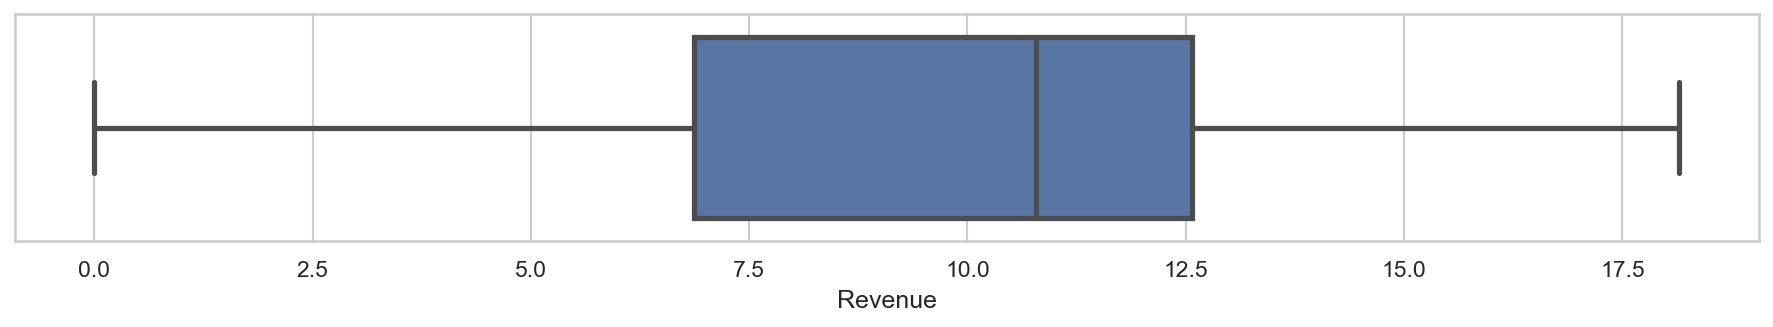

In [142]:
fig, axs = plt.subplots(ncols=1, figsize=(15, 2))
ax = sns.boxplot(original_df.Revenue)
plt.show()

In [269]:
# #Determine rolling statistics
test_df = test_df.drop(columns=["Day"], errors="ignore")
test_df["Rolling Mean"] = test_df.Revenue.rolling(window=12).mean() # 12 months, giving rolling mean at yearly level
test_df["Rolling Std."] = test_df.Revenue.rolling(window=12).std() # 12 months, giving rolling standard deviation at yearly level
test_df["Rolling Variance"] = test_df.Revenue.rolling(window=12).var() # 12 months, giving rolling variance at yearly level

# Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.
# Differencing is performed by subtracting the previous observation from the current observation.
# Taking the difference between consecutive observations is called a lag-1 difference.
# Temporal structure may still exist after performing a differencing operation, such as in the case of a nonlinear trend.
# As such, the process of differencing can be repeated more than once until all temporal dependence has been removed.
# The number of times that differencing is performed is called the difference order.
test_df["Diff"] = test_df.Revenue.diff(periods=1)

test_df


,Revenue,Rolling Mean,Rolling Std.,Diff,Rolling Variance
Date,,,,,
2020-01-01,0.00,NaN,NaN,NaN,NaN
2020-01-02,0.00,NaN,NaN,0.00,NaN
2020-01-03,0.83,NaN,NaN,0.82,NaN
2020-01-04,0.32,NaN,NaN,-0.51,NaN
2020-01-05,1.08,NaN,NaN,0.76,NaN
...,...,...,...,...,...
2021-12-27,16.93,17.42,0.47,0.17,0.22
2021-12-28,17.49,17.45,0.46,0.56,0.21
2021-12-29,16.80,17.35,0.47,-0.69,0.22


[Text(0.5, 1.0, 'Revenue')]

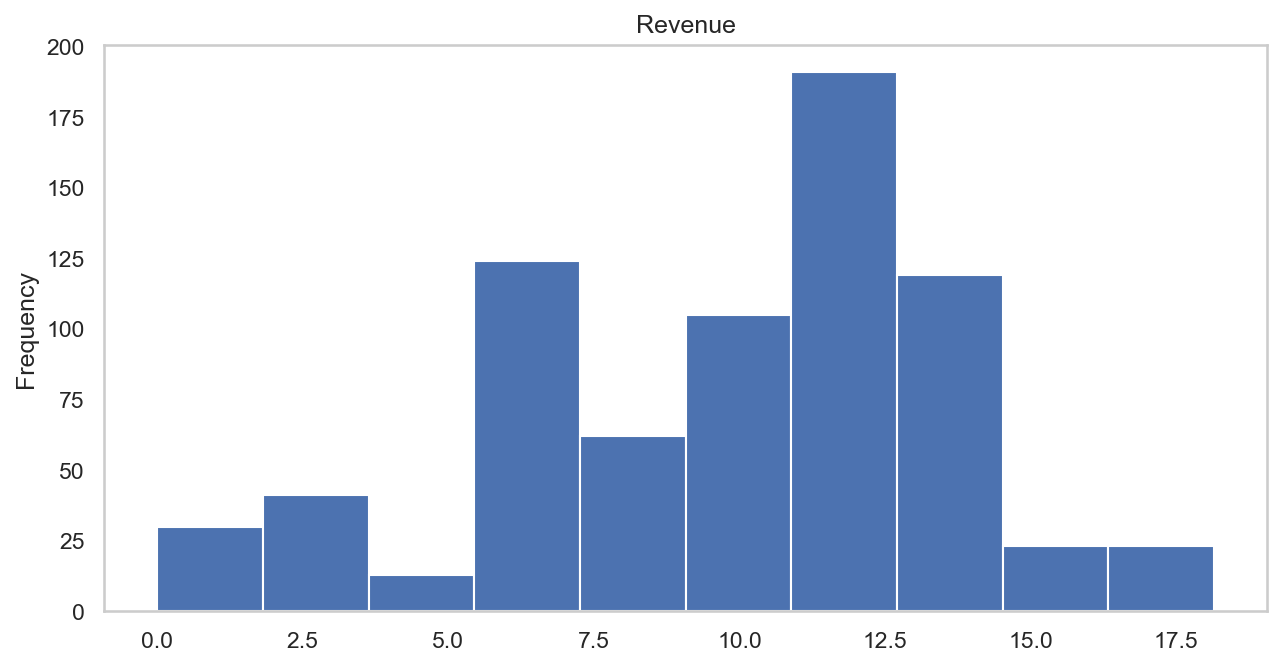

In [270]:
ax = original_df.Revenue.plot.hist()
ax.set(title="Revenue")
ax.grid(False)
plt.show()

In [348]:
X = test_df.Revenue
split = round(len(X) / 2)
split
# X1, X2 = X[0:split], X[split:]

pd.DataFrame([
    {
        **test_df.iloc[:split, :].Revenue.describe(),
        "variance": test_df.iloc[:split, :].Revenue.var()
    }, 
    {
        **test_df.iloc[split:, :].Revenue.describe(),
        "variance": test_df.iloc[split:, :].Revenue.var()
    },    
],
    index=["Partition 1", "Partition 2"]
)
# test_df.iloc[:split, :].Revenue.describe()
# test_df.iloc[:split, :].Revenue.var()

366

,count,mean,std,min,25%,50%,75%,max,variance
Partition 1,366.00,6.81,2.95,0.00,5.63,6.87,9.23,12.44,8.68
Partition 2,365.00,12.84,1.68,9.80,11.83,12.57,13.63,18.15,2.83


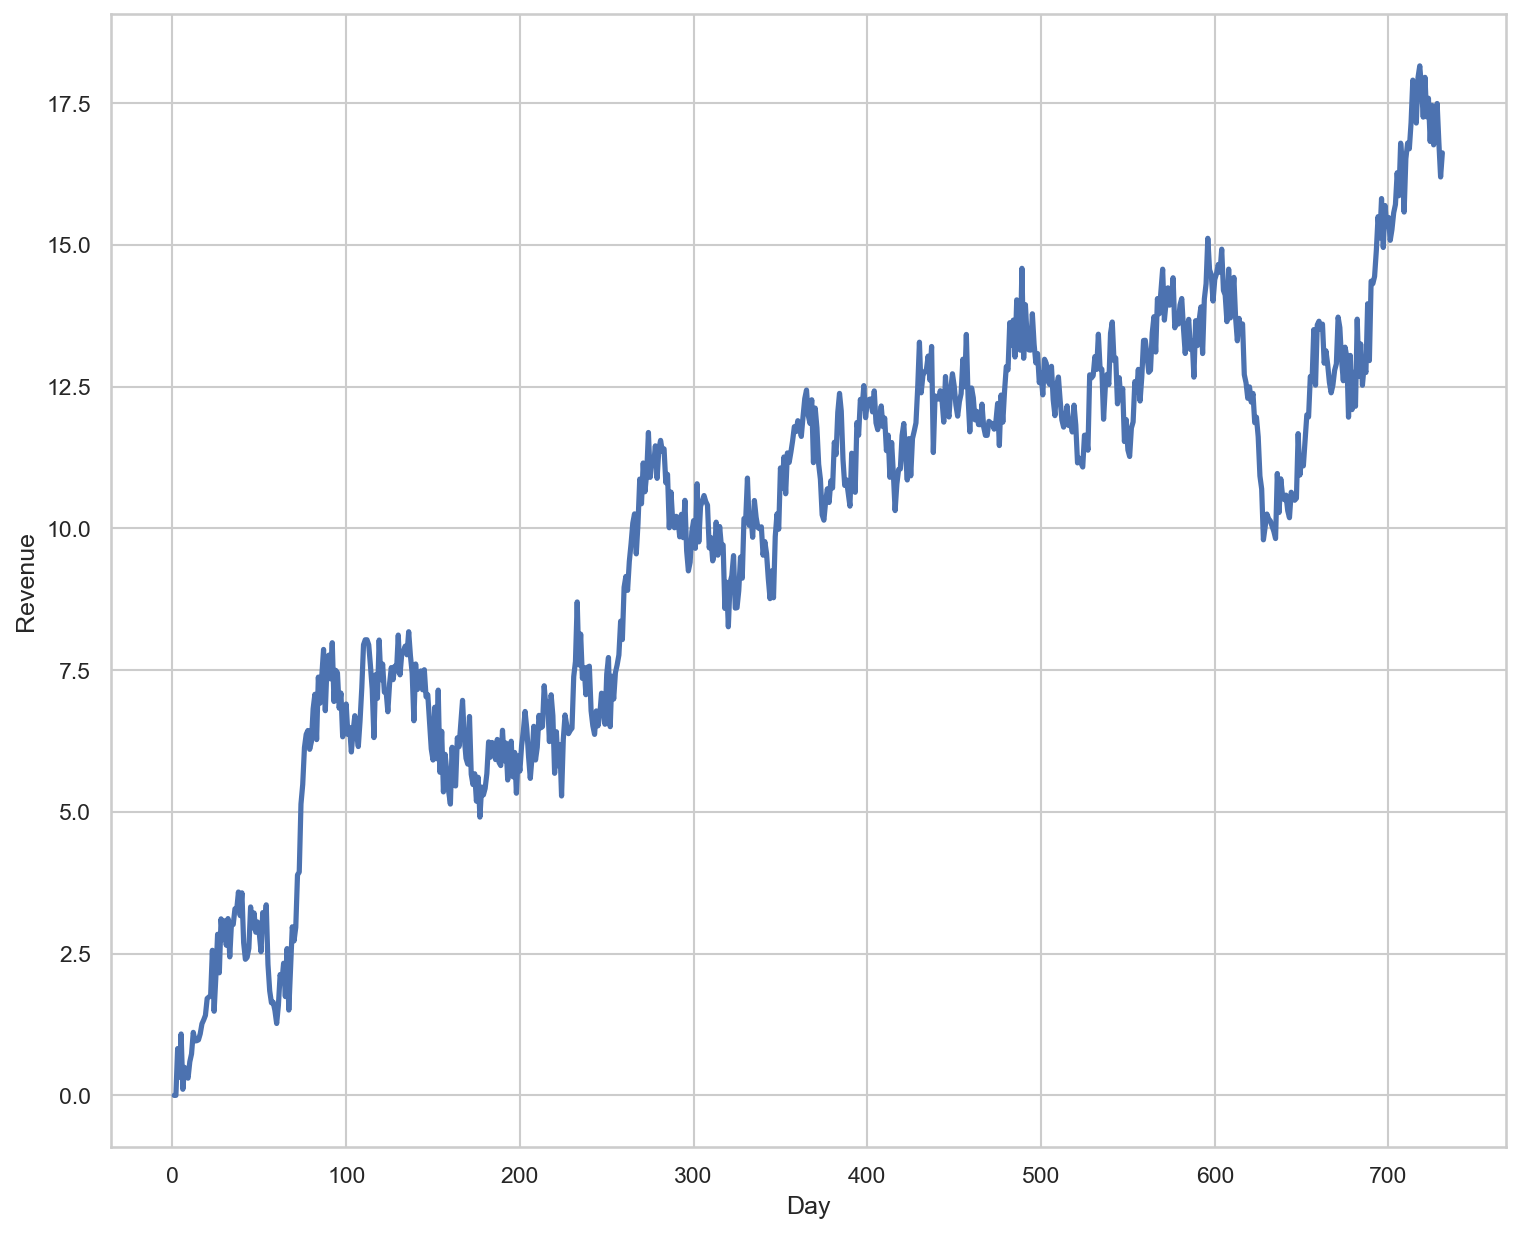

In [53]:
ax = sns.lineplot(data=original_df, x="Day", y="Revenue")

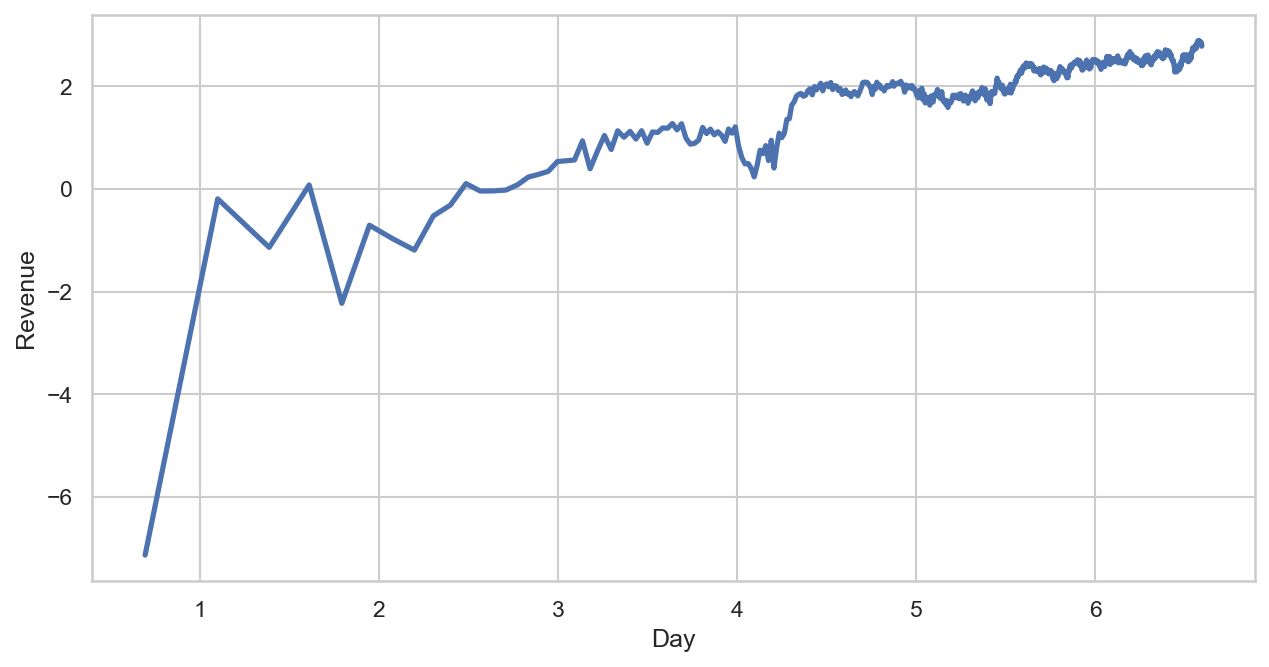

In [350]:
ax = sns.lineplot(data=np.log(prep_df), x="Day", y="Revenue")

,Day,Revenue
Date,,
2020-01-01,1,0.00
2020-01-02,2,0.00
2020-01-03,3,0.83
2020-01-04,4,0.32
2020-01-05,5,1.08


<Figure size 1500x750 with 0 Axes>

Text(0.5, 1.0, 'Revenue Chart')

Text(0.5, 0, 'Day')

Text(0, 0.5, 'Revenue (in Millions USD)')

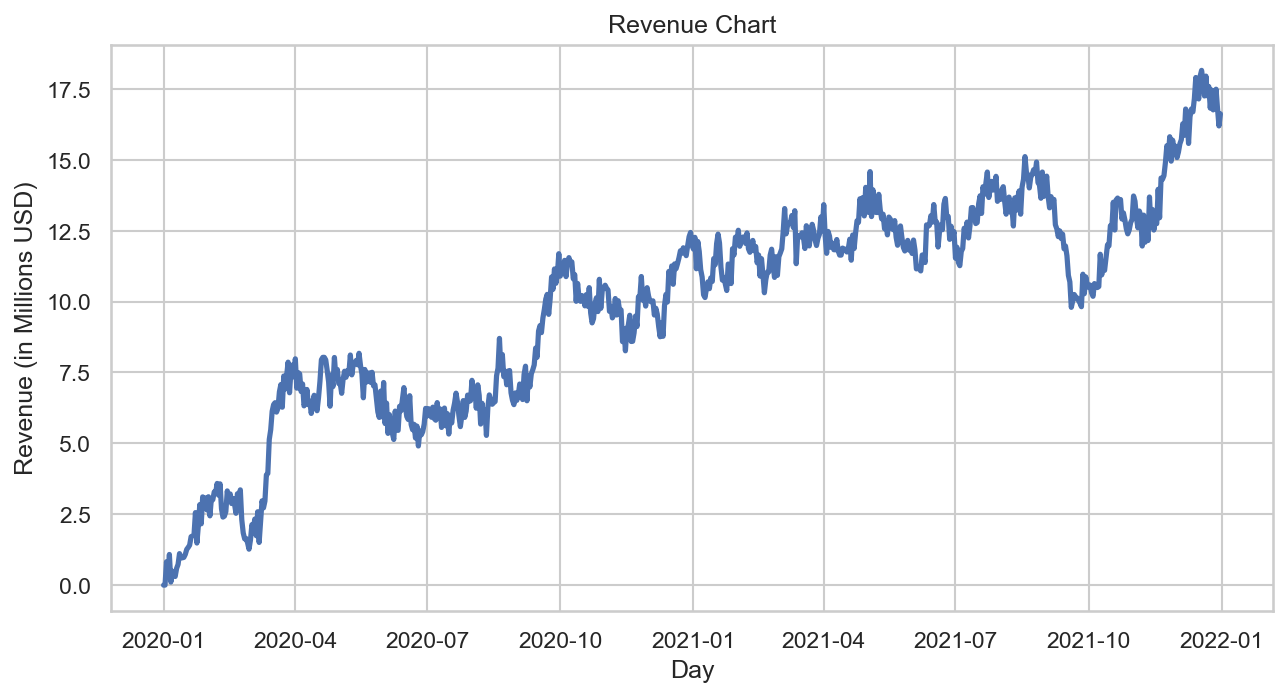

In [110]:
from datetime import datetime
# original_df
test_df = original_df.copy()

test_df['Date'] = pd.date_range(start=datetime(2020, 1, 1), periods=len(original_df), freq='24H')

# Set the Date as an index
test_df.set_index('Date',inplace=True)


# test_df['dt'] = pd.to_datetime(original_df['Day'],infer_datetime_format=True)
# test_df = test_df.reset_index(drop=True).set_index(['dt'])

test_df.head(5)

# plt.xlabel('Date')
# plt.ylabel('Number of air passengers')
# plt.plot(test_df)

plt.figure(figsize=(10,5))
plt.plot(test_df.Revenue)
plt.title('Revenue Chart')
plt.xlabel('Day')
plt.ylabel('Revenue (in Millions USD)')
plt.grid(True)
plt.show()


# #Determine rolling statistics
# rolmean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
# rolstd = indexedDataset.rolling(window=12).std()
# print(rolmean,rolstd)





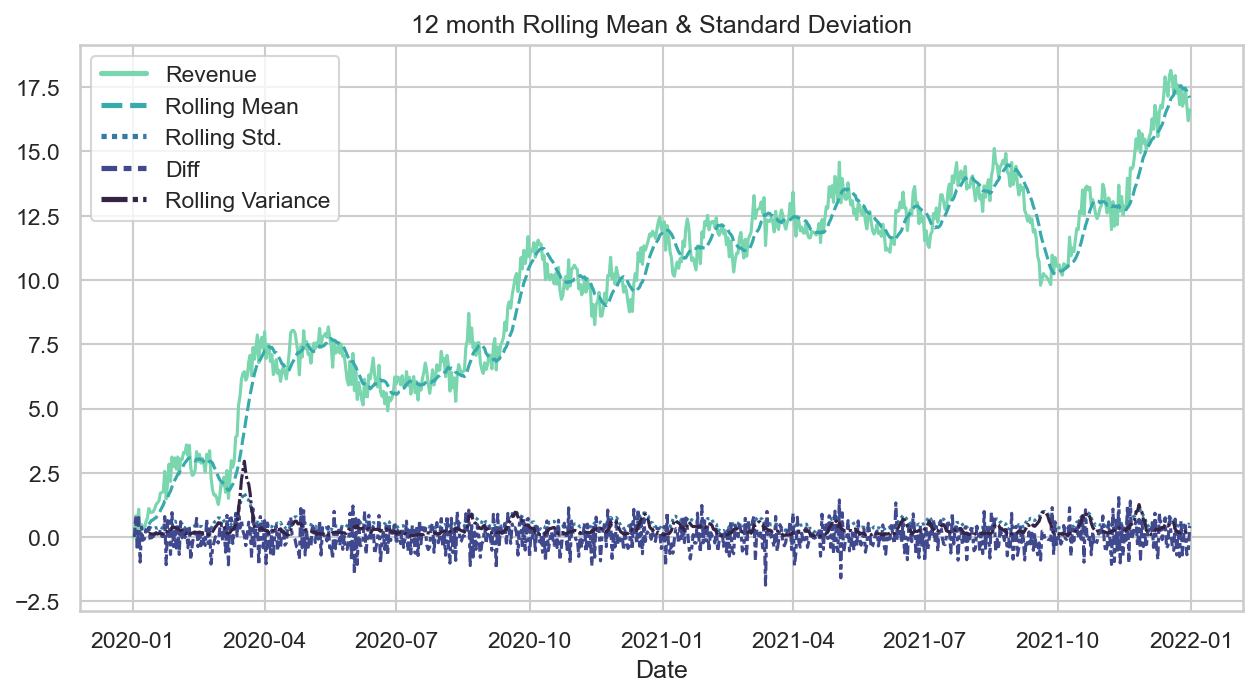

In [219]:
# Plot rolling statistics
palette = sns.color_palette("mako_r", 5)

ax = sns.lineplot(data=test_df, palette=palette, linewidth=1.5)
_ = ax.legend(loc='best')
_ = ax.set(title='12 month Rolling Mean & Standard Deviation')
plt.show()

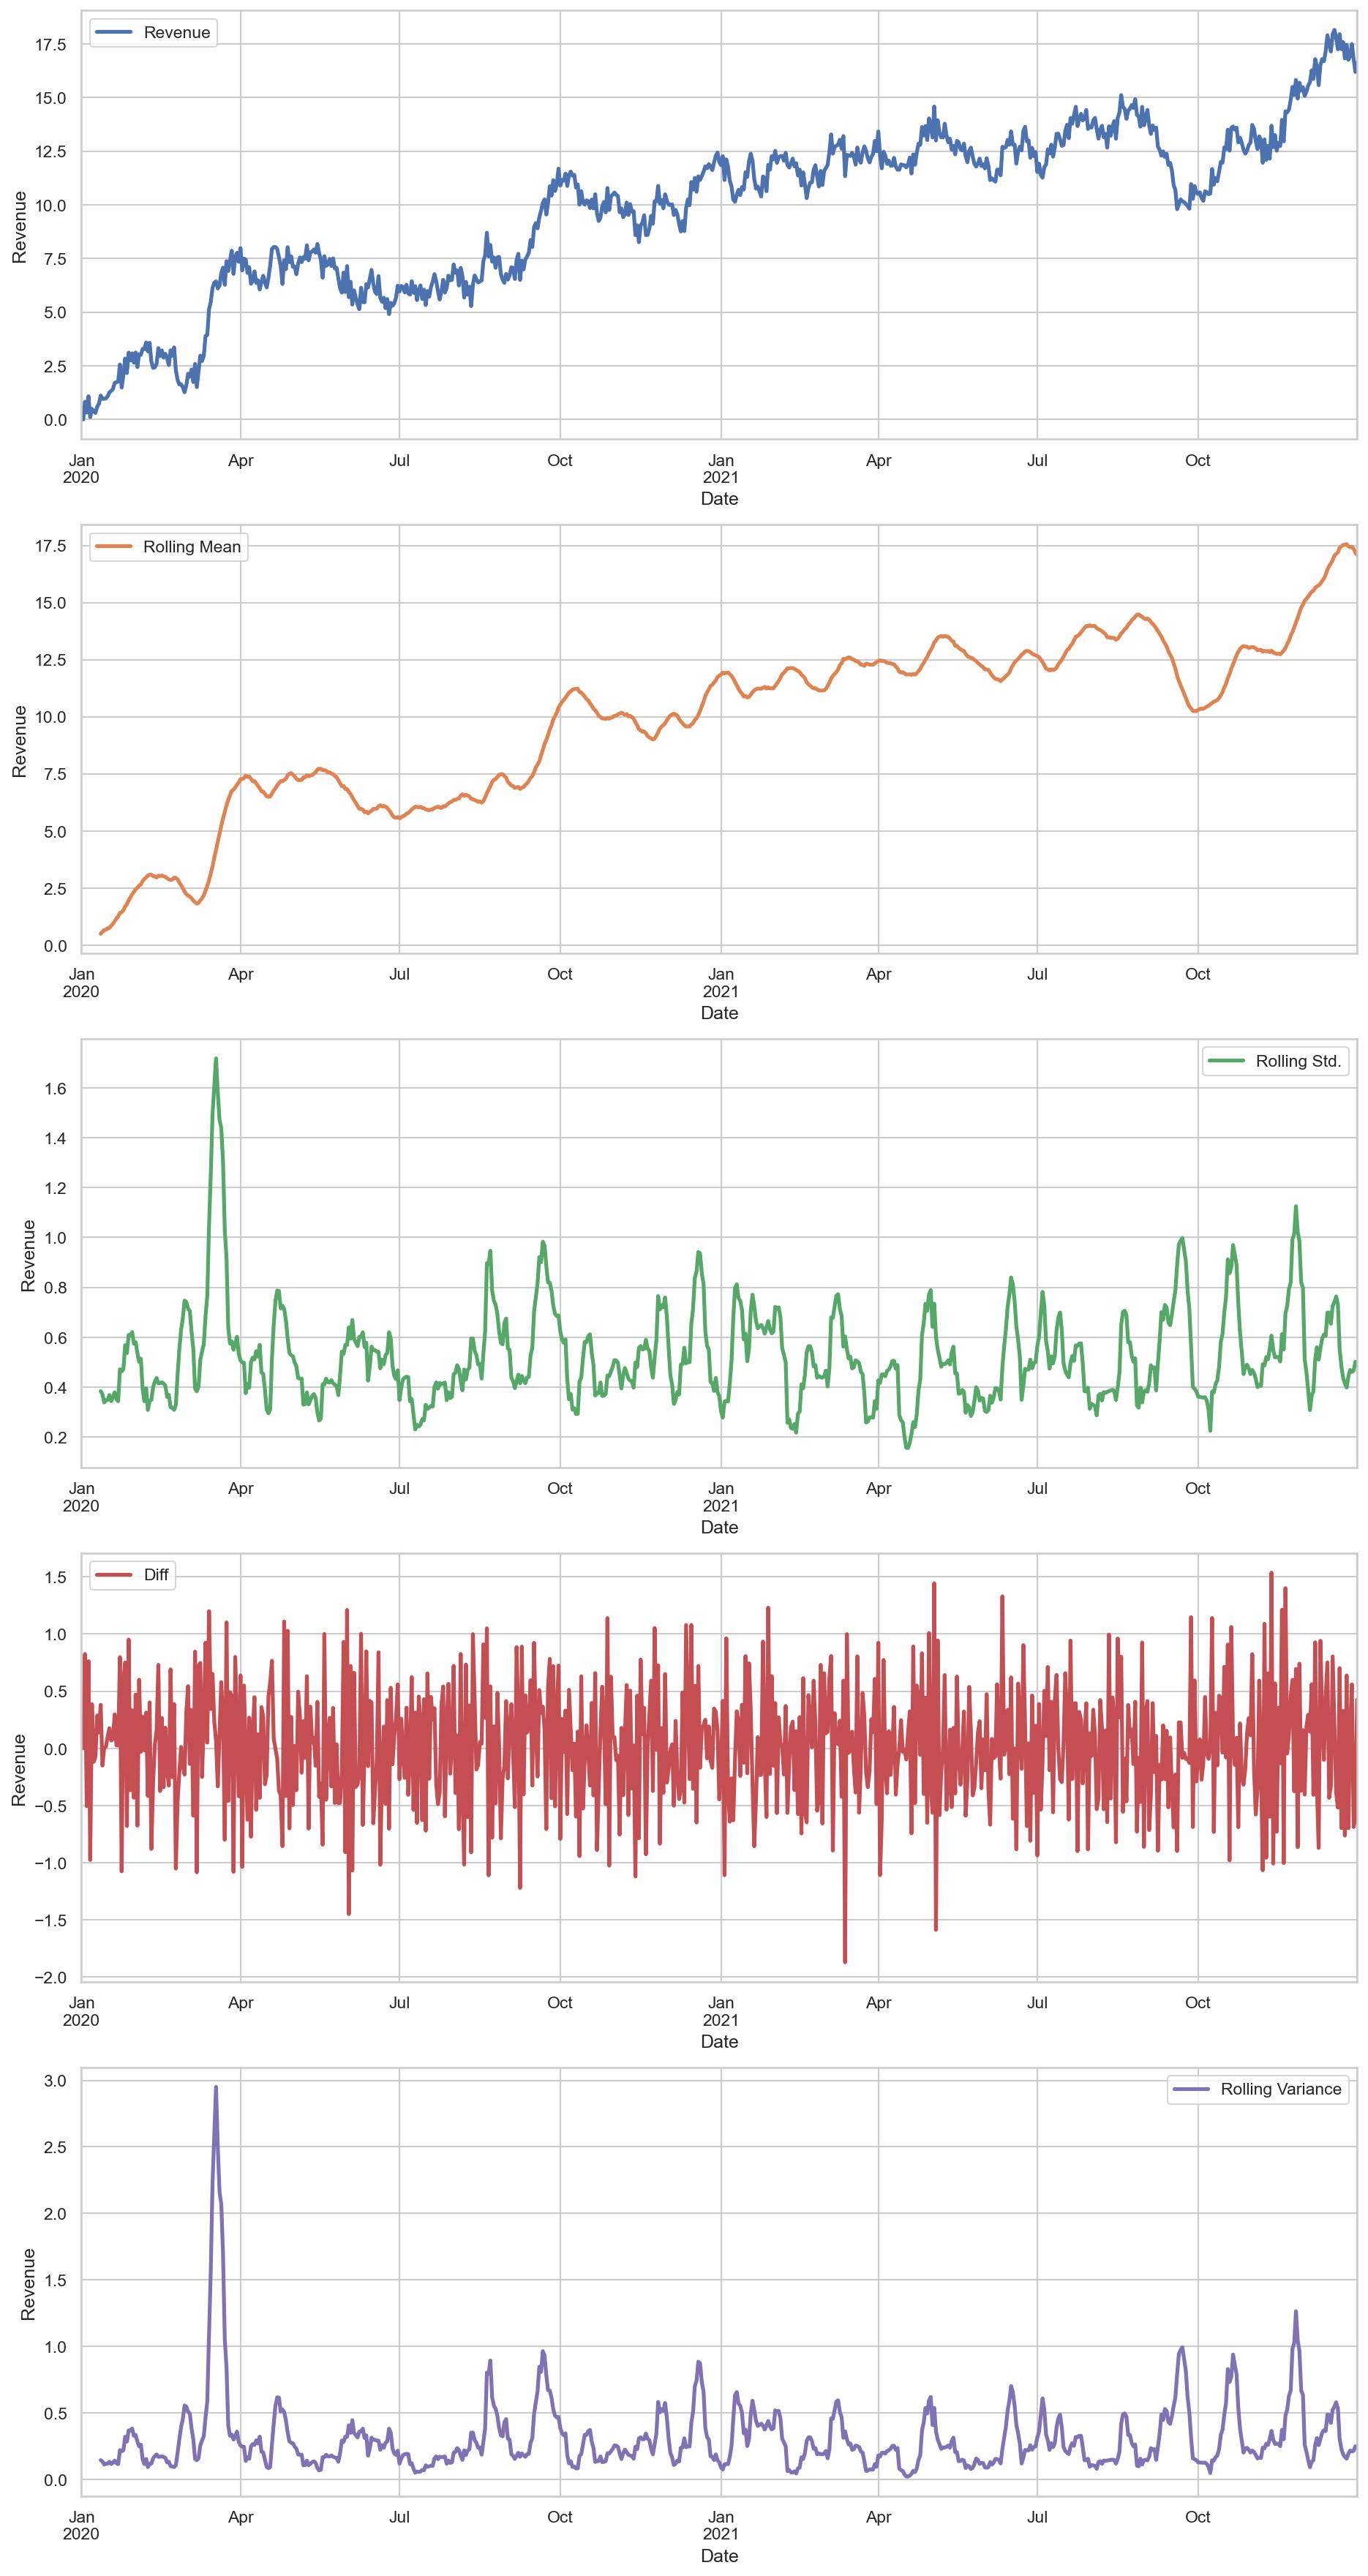

In [268]:
ax = test_df.plot(kind="line", subplots=True, figsize=(15,30), use_index=True, sharex=False, ylabel="Revenue")

plt.show()

In [ ]:
# Differencing
# In Figure 8.1, note that the Google stock price was non-stationary in panel (a), but the daily changes were stationary in panel (b). This shows one way to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as differencing.

<AxesSubplot:>

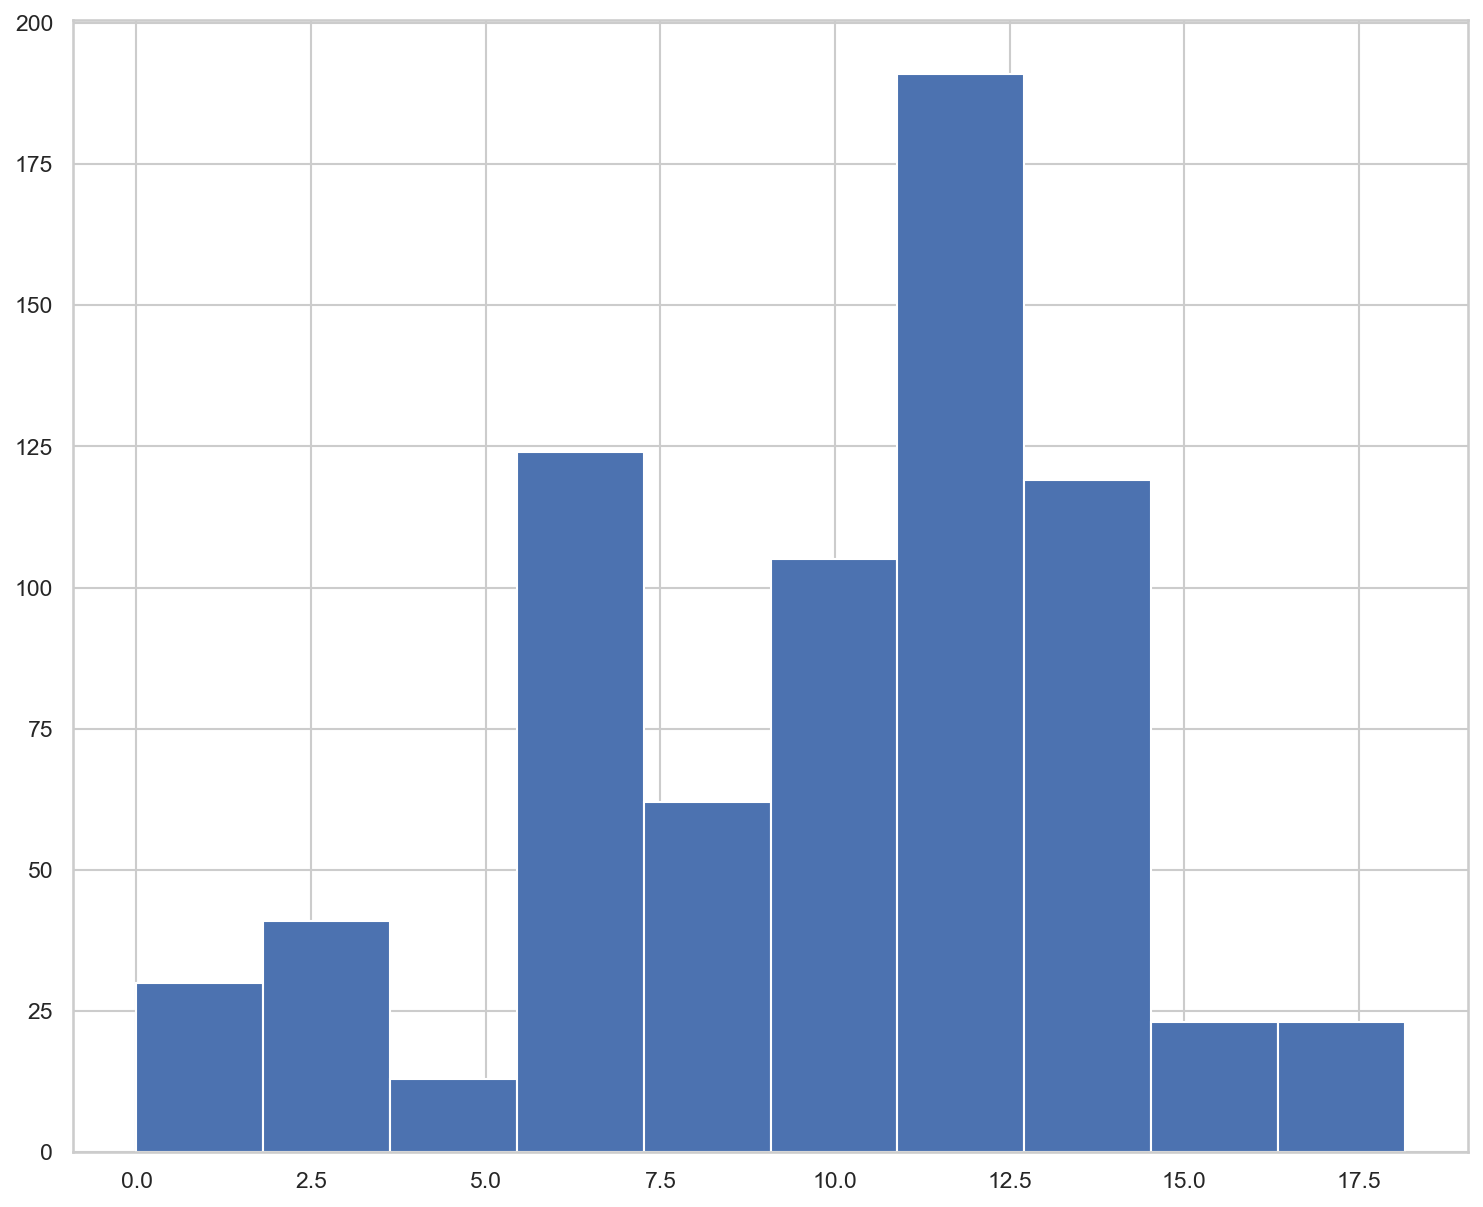

In [112]:
test_df.Revenue.hist()

In [124]:
from statsmodels.tsa.stattools import adfuller
X = test_df.Revenue.values
# Augmented Dickey-Fuller unit root test.
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:', result[4])

ADF Statistic: -1.924612
p-value: 0.320573
Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [62]:
n = len(original_df)
fhat = np.fft.fft(original_df, n)
# original_df.shape
fhat

# Power Spectral Density
PSD = fhat * np.conj(fhat) / n
PSD


array([[  1.        +0.00000000e+00j,   1.        +0.00000000e+00j,
          1.        +0.00000000e+00j, ...,   1.        +0.00000000e+00j,
          1.        +0.00000000e+00j,   1.        +0.00000000e+00j],
       [  2.00079319+0.00000000e+00j,   2.00079316-6.81765345e-06j,
          2.00079307-1.36348032e-05j, ...,   2.00079293+2.04509457e-05j,
          2.00079307+1.36348032e-05j,   2.00079316+6.81765345e-06j],
       [  3.82554179+0.00000000e+00j,   3.82551129-7.09571567e-03j,
          3.82541981-1.41909071e-02j, ...,   3.82526734+2.12850501e-02j,
          3.82541981+1.41909071e-02j,   3.82551129+7.09571567e-03j],
       ...,
       [745.80363798+0.00000000e+00j, 745.80301726-1.44431014e-01j,
        745.80115515-2.88851358e-01j, ..., 745.79805178+4.33250361e-01j,
        745.80115515+2.88851358e-01j, 745.80301726+1.44431014e-01j],
       [746.1948135 +0.00000000e+00j, 746.19421527-1.39198032e-01j,
        746.19242062-2.78385780e-01j, ..., 746.18942969+4.17552961e-01j,
       

array([[1.36798906e-03+0.j, 1.36798906e-03+0.j, 1.36798906e-03+0.j, ...,
        1.36798906e-03+0.j, 1.36798906e-03+0.j, 1.36798906e-03+0.j],
       [5.47629739e-03+0.j, 5.47629723e-03+0.j, 5.47629675e-03+0.j, ...,
        5.47629595e-03+0.j, 5.47629675e-03+0.j, 5.47629723e-03+0.j],
       [2.00202051e-02+0.j, 2.00199548e-02+0.j, 2.00192039e-02+0.j, ...,
        2.00179525e-02+0.j, 2.00192039e-02+0.j, 2.00199548e-02+0.j],
       ...,
       [7.60907068e+02+0.j, 7.60905830e+02+0.j, 7.60902116e+02+0.j, ...,
        7.60895926e+02+0.j, 7.60902116e+02+0.j, 7.60905830e+02+0.j],
       [7.61705472e+02+0.j, 7.61704277e+02+0.j, 7.61700692e+02+0.j, ...,
        7.61694719e+02+0.j, 7.61700692e+02+0.j, 7.61704277e+02+0.j],
       [7.64619505e+02+0.j, 7.64618277e+02+0.j, 7.64614594e+02+0.j, ...,
        7.64608454e+02+0.j, 7.64614594e+02+0.j, 7.64618277e+02+0.j]])

,autocorrelation
0,1.00
1,0.98
2,0.98
3,0.97
4,0.96


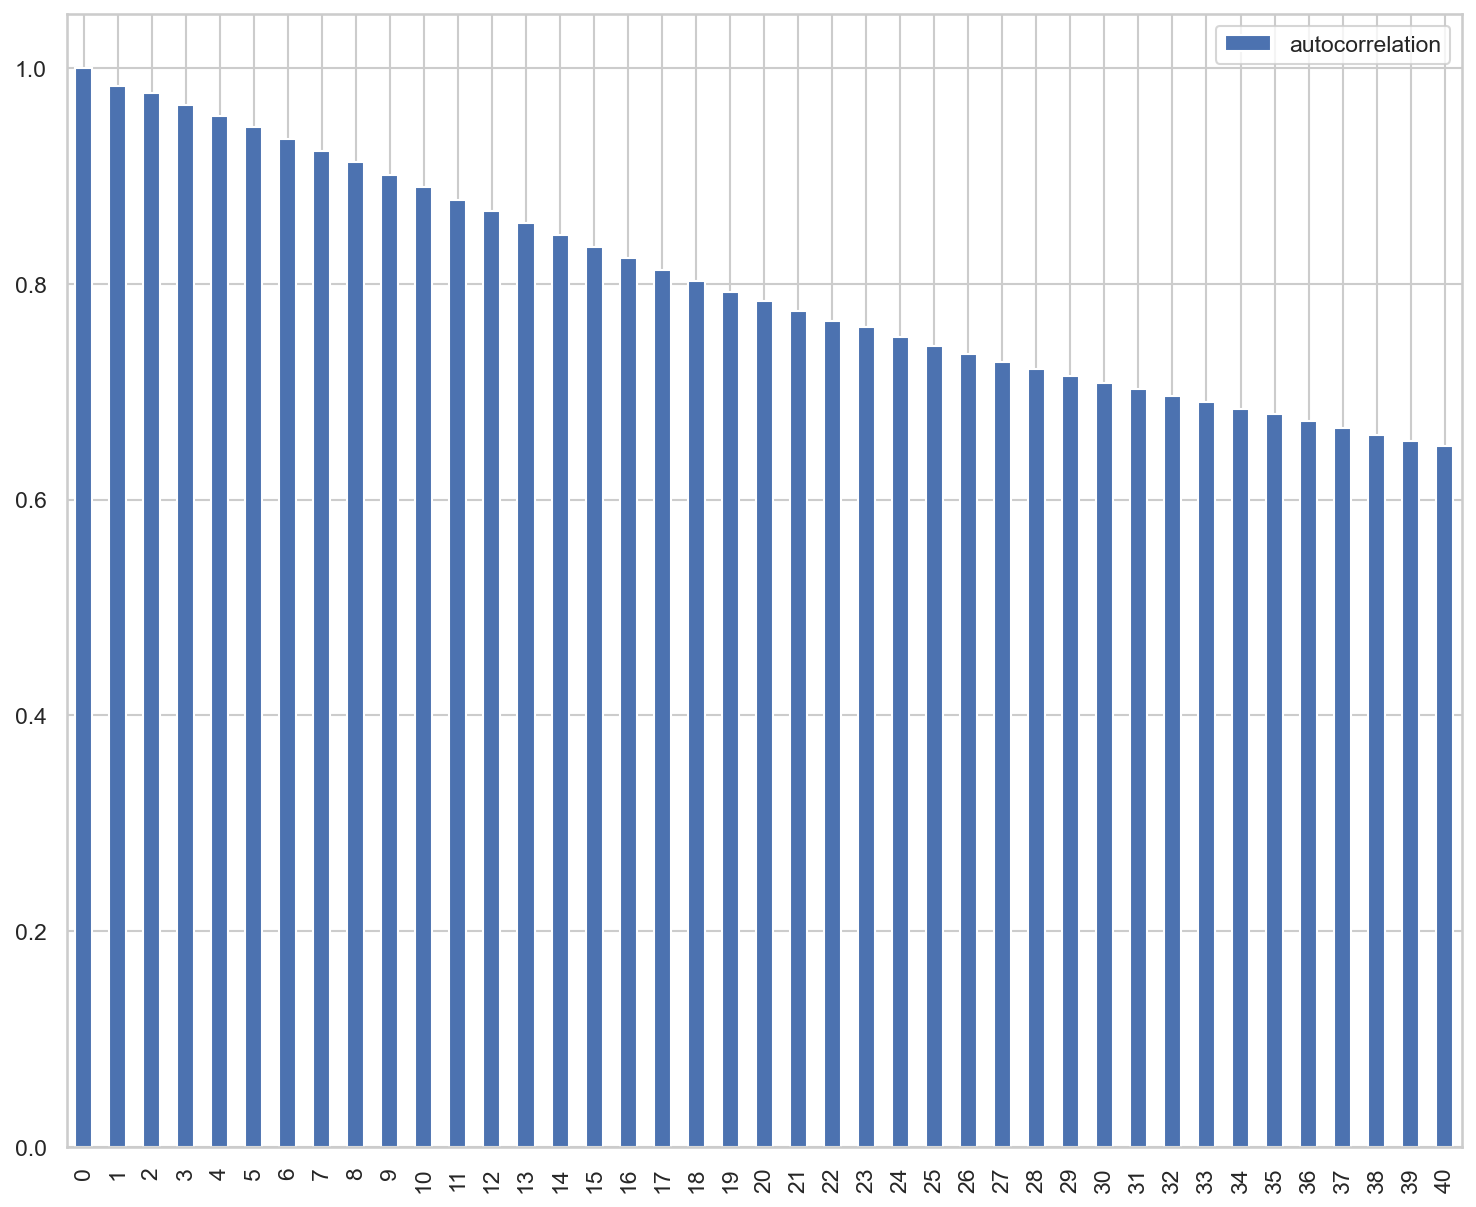

In [31]:
# stationarity
acf
# The autocorrelation function.
acf_1 = pd.DataFrame(acf(original_df.Revenue), columns=["autocorrelation"])

acf_1.head()

ax = acf_1.plot(kind="bar")




<function statsmodels.tsa.stattools.pacf(x, nlags=None, method='ywadjusted', alpha=None)>

,partial_autocorrelation
0,1.00
1,0.99
2,0.31
3,-0.05
4,-0.04


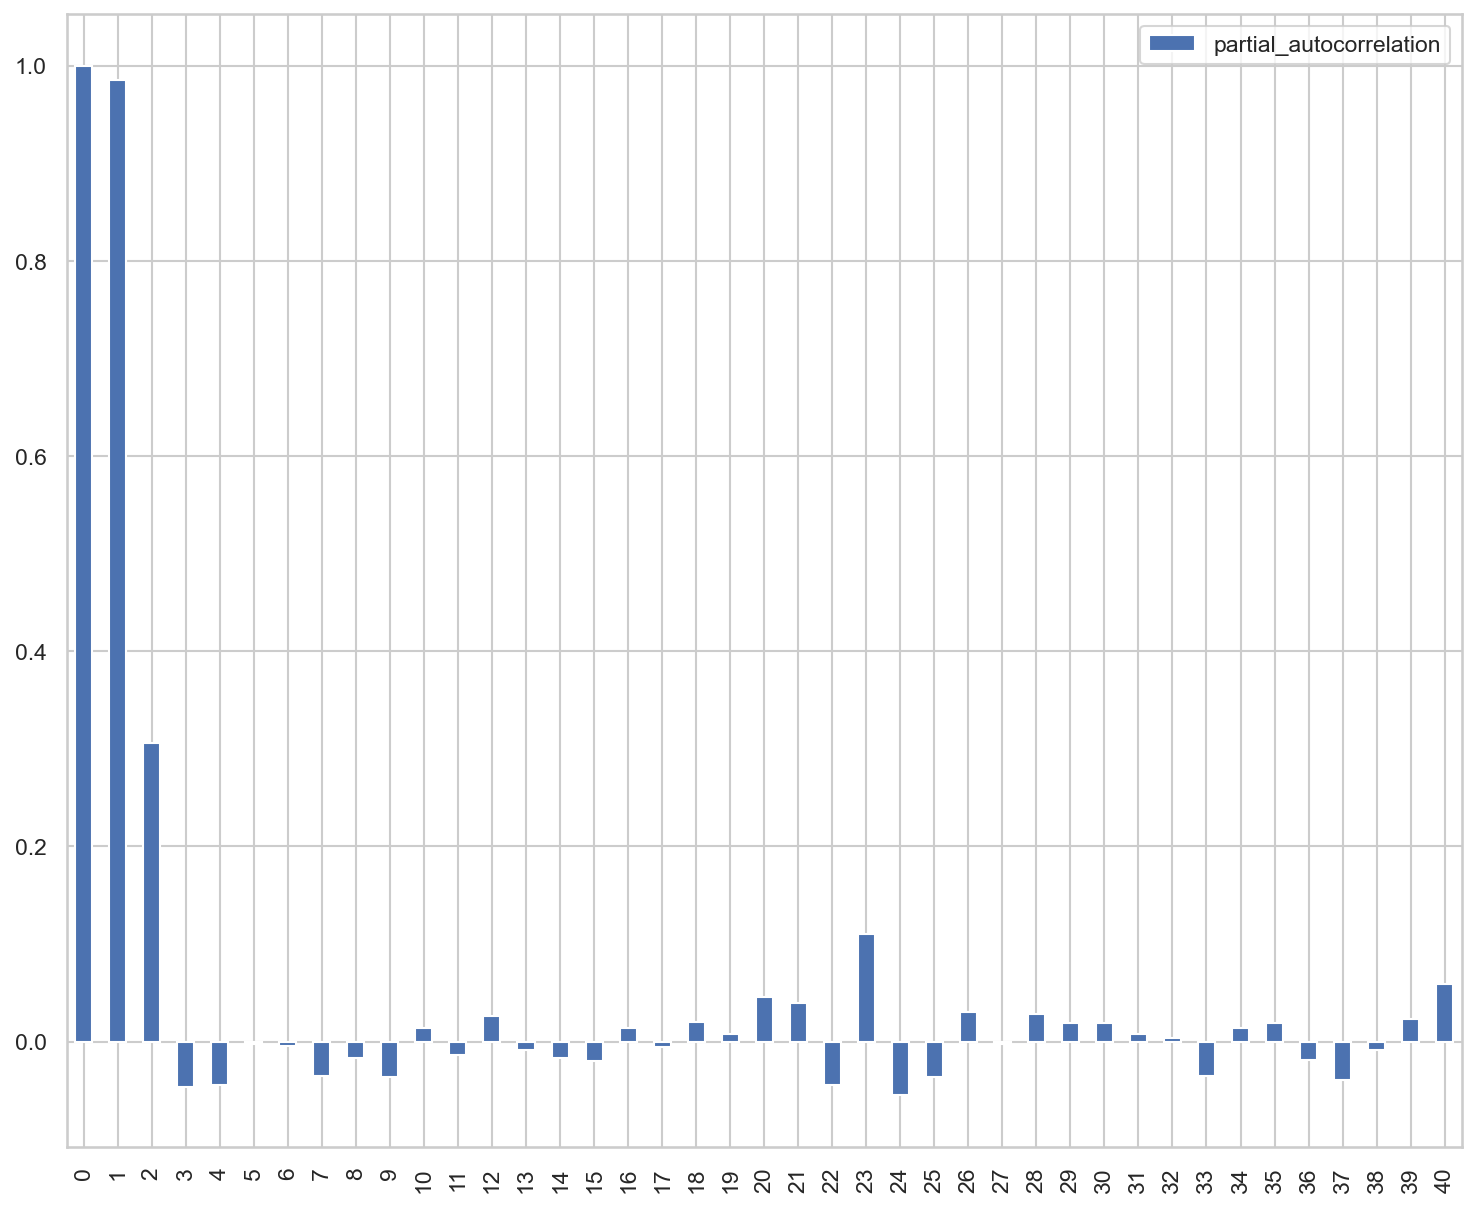

In [32]:
pacf

# Partial autocorrelation estimate.
acf_1 = pd.DataFrame(pacf(original_df.Revenue), columns=["partial_autocorrelation"])

acf_1.head()

ax = acf_1.plot(kind="bar")



<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Revenue   No. Observations:                  730
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -579.409
Method:                           css   S.D. of innovations              0.535
Date:                Tue, 06 Sep 2022   AIC                           1162.819
Time:                        20:47:06   BIC                           1172.005
Sample:                             1   HQIC                          1166.363
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0228      0.020      1.150      0.250      -0.016       0.062
==============================================================================
"""

2     0.02
3     0.02
4     0.02
5     0.02
6     0.02
      ... 
726   0.02
727   0.02
728   0.02
729   0.02
730   0.02
Length: 729, dtype: float64

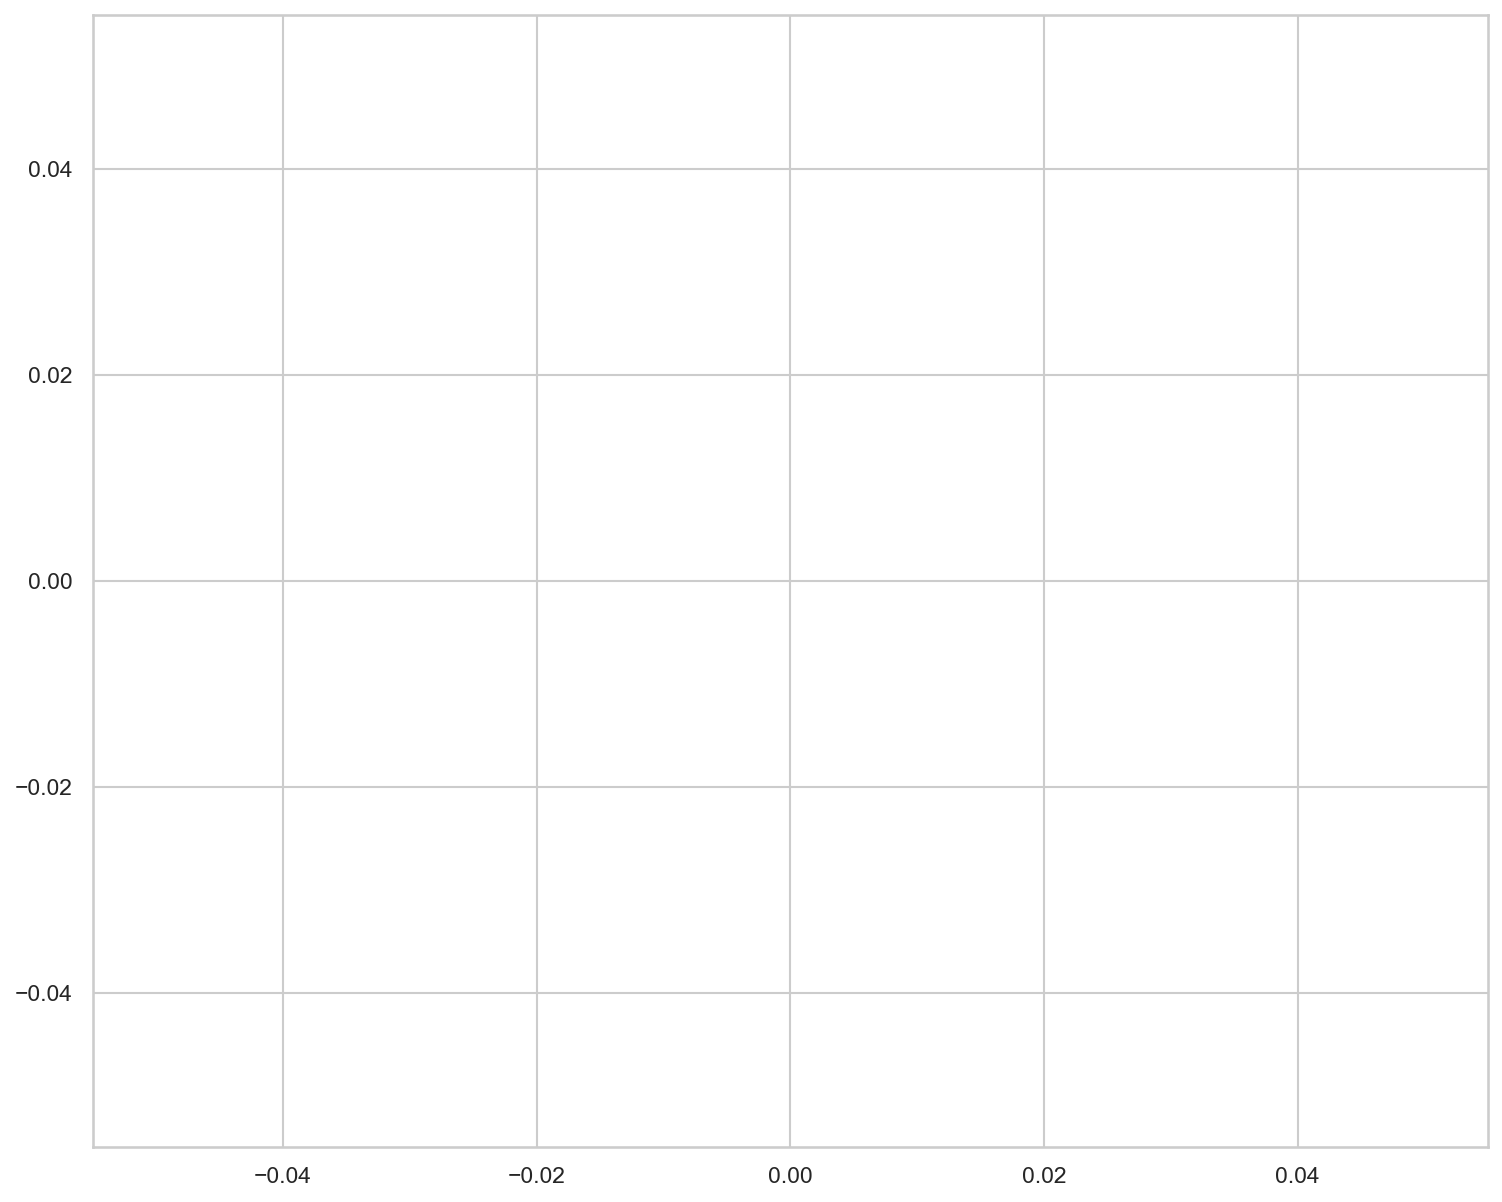

In [52]:
# Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
model = ARIMA(original_df.Revenue, order=(0,1,0))
f = model.fit(disp=0)

f.summary()

preds = f.predict()
preds
ax = sns.lineplot(preds)
plt.show()

In [365]:
# Augmented Dickey-Fuller test
# use a statistical test designed to explicitly comment on whether a univariate time series is stationary.

# """
# Augmented Dickey-Fuller test
# Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.

# Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.

# The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

# The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

# There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

# The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

# Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
# Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
# We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
# """

result = adfuller(test_df.Revenue)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:', result[4])


ADF Statistic: -1.924612
p-value: 0.320573
Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


Running the example prints the test statistic value of -1.9. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -1.9 is greater than the value of -3.4 at 1%.

This suggests that we fail to reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Failing to reject the null hypothesis means that the process has a unit root, and in turn that the time series is non-stationary or has a time-dependent structure.

shows a negative value for the test statistic.

We can see that the value is larger than the critical values, again, meaning that we can fail to reject the null hypothesis and in turn that the time series is non-stationary.

# Part I:  Research Question
## A.  Describe the purpose of this data analysis by doing the following:disp=

### 1.  Summarize one research question that is relevant to a real-world organizational situation captured in the selected data set and that you will answer using time series modeling techniques.

- Detect seasonality of revenue?
- Predict revenue for next 5 years?
- Ex 1. What should be our revenue forecast for the upcoming year?
- Ex 2. Is it possible to forecast the daily revenue of the company for the next quarter so that the company can plan a project for network capacity expansions for its customers?
- Ex 3. Using the previous two years of data, are there any patterns present that can predict the
revenue produced by the hospital for the next quarter?
- Ex 4. Is it possible to discern significant trends in our hospital network’s revenue over the past two years using time series analysis?

### 2.  Define the objectives or goals of the data analysis. Ensure that your objectives or goals are reasonable within the scope of the scenario and are represented in the available data.

- Ex 1. To build a predictive model that will forecast future revenue, by analyzing the revenue by day for the past two years to identify overall trends, seasonality, and other factors.
- Ex 2. To use time series modeling to forecast the daily revenue of the company for the next quarter. 
- Ex 3. To identify significant patterns in revenue that can help us determine when readmissions occur within our network of hospitals. The insights from time-series revenue information will help us determine whether readmission rates are correlated with trends in daily revenue.

# Part II:  Method Justification

## B.  Summarize the assumptions of a time series model including stationarity and autocorrelated data.

Time Series Assumptions
1. The time series data should be stationary. It means the series is normally distributed and the mean and variance are constant over that period of time. The series has zero trends, it is not growing or shrinking. The variance is constant. The autocorrelation is constant (Datacamp, n.d).
2. The error term is randomly distributed, and the mean and the variance are constant over a time period. The error in time series analysis is assumed to be uncorrelated.
3. There should be no outliers in the series. Outliers could lead to inaccurate results (Statistics Solutions, 2021).
4. The residuals aren’t autocorrelated. 


Stationarity: is an assumption in Time Series that that the mean, variance and autocorrelation structure do not change over time (Sematech, Sangarshanan, 2018). It means that the distribution of the data does not change with time. For Time Series to be stationary it must fulfill these three criteria: 
1)	The series has zero trends, it is not growing or shrinking.
2)	The variance is constant.
The autocorrelation is constant. How each value in the time series is related to its neighbors stay the same (Datacamp, n.d).


# Part III:  Data Preparation
## C.  Summarize the data cleaning process by doing the following:

In [126]:
prep_df = original_df.copy()

### 1.  Provide a line graph visualizing the realization of the time series.


### 2.  Describe the time step formatting of the realization, including any gaps in measurement and the length of the sequence.


### 3.  Evaluate the stationarity of the time series.
- https://otexts.com/fpp2/stationarity.html
- https://machinelearningmastery.com/time-series-data-stationary-python/

A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

Some cases can be confusing — a time series with cyclic behaviour (but with no trend or seasonality) is stationary. This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be.

In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

For a time series to be stationary, it should satisfy the following 3 conditions:
- Mean (μ) is constant
- Standard Deviation (σ) is constant
- Seasonality doesn’t exist

- For example, when modeling, there are assumptions that the summary statistics of observations are consistent. In time series terminology, we refer to this expectation as the time series being stationary. These assumptions can be easily violated in time series by the addition of a trend, seasonality, and other time-dependent structures. The observations in a stationary time series are not dependent on time. Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations. When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.

- Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time index. Summary statistics like the mean and variance do change over time, providing a drift in the concepts a model may try to capture. Classical time series analysis and forecasting methods are concerned with making non-stationary time series data stationary by identifying and removing trends and removing seasonal effects.

- If we fit a stationary model to data, we assume our data are a realization of a stationary process. So our first step in an analysis should be to check whether there is any evidence of a trend or seasonal effects and, if there is, remove them.

- The suggestion here is to treat properties of a time series being stationary or not as another source of information that can be used in feature engineering and feature selection on your time series problem when using machine learning methods.

- Checks for Stationarity
    - There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary.
        - Look at Plots: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
        - Summary Statistics: You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.
        - Statistical Tests: You can use statistical tests to check if the expectations of stationarity are met or have been violated.
    - A quick and dirty check to see if your time series is non-stationary is to review summary statistics. You can split your time series into two (or more) partitions and compare the mean and variance of each group. If they differ and the difference is statistically significant, the time series is likely non-stationary.


### 4.  Explain the steps used to prepare the data for analysis, including the training and test set split.


#### Check for and Impute Missing Values

In [153]:
def missing_val_summary(df):
    return pd.DataFrame(
        {
            "# missing values": df.isna().sum(),
            "% missing values": (df.isna().sum() / len(prep_df)) * 100,
        }
    )    

In [154]:
missing_val_summary(df=prep_df)

,# missing values,% missing values
Day,0,0.00
Revenue,0,0.00


In [151]:
prep_df = pd.DataFrame(
    Pipeline(
        steps=[
            ("imp", SimpleImputer(missing_values=np.nan, strategy="median")),
        ]
    ).fit_transform(prep_df),
    columns=prep_df.columns,
)

prep_df

,Day,Revenue
0,1.00,0.00
1,2.00,0.00
2,3.00,0.83
3,4.00,0.32
4,5.00,1.08
...,...,...
726,727.00,16.93
727,728.00,17.49
728,729.00,16.80
729,730.00,16.19


In [155]:
missing_val_summary(df=prep_df)

,# missing values,% missing values
Day,0,0.00
Revenue,0,0.00


### Train Test Split

In [ ]:
X = df.Date 
y = df.Revenue

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### 5.  Provide a copy of the cleaned dataset.

In [ ]:
prep_df.to_csv("./teleco_time_series_prepared.csv", index=False)


# Part IV:  Model Identification and Analysis
## D.  Analyze the time series dataset by doing the following:

### 1.  Report the annotated findings with visualizations of your data analysis, including the following elements:

#### the presence or lack of a seasonal component

#### trends

#### auto correlation function

#### spectral density

#### the decomposed time series

#### confirmation of the lack of trends in the residuals of the decomposed series


### 2.  Identify an autoregressive integrated moving average (ARIMA) model that takes into account the observed trend and seasonality of the time series data.


### 3.  Perform a forecast using the derived ARIMA model.



### 4.  Provide the output and calculations of the analysis you performed.



### 5.  Provide the code used to support the implementation of the time series model.

# Part V:  Data Summary and Implications
## E.  Summarize your findings and assumptions, including the following points:

### 1.  Discuss the results of your data analysis, including the following:

#### the selection of an ARIMA model

#### the prediction interval of the forecast

#### a justification of the forecast length

#### the model evaluation procedure and error metric


### 2.  Provide an annotated visualization of the forecast of the final model compared to the test set.

### 3.  Recommend a course of action based on your results.

# Part VI: Reporting

## F.  Create your report from part E using an industry-relevant interactive development environment (e.g., a Jupyter Notebook). Include a PDF or HTML document of your executed notebook presentation.


## G. List the web sources used to acquire data or segments of third-party code to support the application.
- [Time Series Forecasting with Machine Learning](https://www.youtube.com/watch?v=_ZQ-lQrK9Rg)
- [x](https://www.kaggle.com/code/freespirit08/time-series-for-beginners-with-arima/notebook)
- https://machinelearningmastery.com/time-series-data-stationary-python/
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- https://machinelearningmastery.com/difference-time-series-dataset-python/


## H. Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

In [ ]:
df.head()


In [ ]:
df.shape


In [ ]:
df.info()


In [ ]:
pd.DataFrame(df.isnull().sum(), columns=["# NaNs"])


In [ ]:
f"{df.isnull().sum().sum():,} Total NaN Cells"
